In [5]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from torch.utils.data import TensorDataset, DataLoader

import optuna
from utils import *
from modules.truncate import SequenceTruncate

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [6]:
class Baseline_LSTM(nn.Module):
    """循环神经网络模型"""
    def __init__(self, input_size, hidden_size, num_layers, dropout, **kwargs):
        super(Baseline_LSTM, self).__init__(**kwargs)
        self.device = 'cuda:0'
        self.hidden_size = hidden_size
        self.truncate = SequenceTruncate(dropout)
        self.process = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = dropout,
            batch_first = True,
            # nonlinearity='relu',
        )
        self.output = nn.Sequential(
            nn.Dropout(dropout),
            HybridDecoder(dim_state = hidden_size, init_prob = [0.0,0.5,0.0])
        )
        

    def forward(self, x):
        #为了提升模型的泛化能力，我们每次输入都随机舍弃一部分前端的序列
        front_shape = x.shape[:-2]
        x = self.truncate(x)
        x = torch.flatten(x, 0, -3)
        x = self.process(x)[0][:,-1,:]
        x = x.reshape(*front_shape, self.hidden_size)
        return self.output(x)

In [7]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True) # 对数均匀分布
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True) # 对数均匀分布
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    seq_len = trial.suggest_categorical("seq_len", [20, 30, 40])
    hidden_size = trial.suggest_categorical('hidden_size', [10,15,20,30])
    num_layers = trial.suggest_categorical('num_layers', [1,2])

    # 提取数据
    feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
    label_columns = ['label_return','down_prob','middle_prob','up_prob']
    assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
    assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX',]
    feature = []
    label = []

    for asset_code in assets_list:
        data = pd.read_csv(f'data/{asset_code}.csv')
        feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
        label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

    # 加载数据
    feature = torch.stack(feature, dim = 1)
    label = torch.stack(label, dim = 1)
    print(feature.shape, label.shape)

    # 折叠时间步
    feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
    label = label[seq_len-1:]
    print(feature.shape, label.shape)

    data = RandomLoader(feature, label)
    recorder = PredictionRecorder()
    animator = TrainMonitor(figsize=(12,6))

    result = np.zeros(shape = (10, len(assets_list), 4))
    precision_list = []

    result = []
    for i in range(10):
        j = 0
        train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.6, 0.1], balance=[True, False])
        
        animator.reset()
        loss_fn = HybridLoss(alpha = 0.02, delta = 1.3, show_loss = False) #控制损失在1：3左右
        model = Baseline_LSTM(input_size = 10, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout).to('cuda:0')
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
        train = ModelTrain(model = model,
                    train_loader = train_loader,
                    test_loader = test_loader,
                    loss_fn = loss_fn,
                    optimizer = optimizer,
                    scheduler = scheduler,
                    recorder = recorder,
                    graph = animator,
                    )
        prediction, precision = train.epoch_train(epochs = 10, early_stop = 100)

        precision_list.append(precision)


    return np.mean(precision_list)/np.std(precision_list)

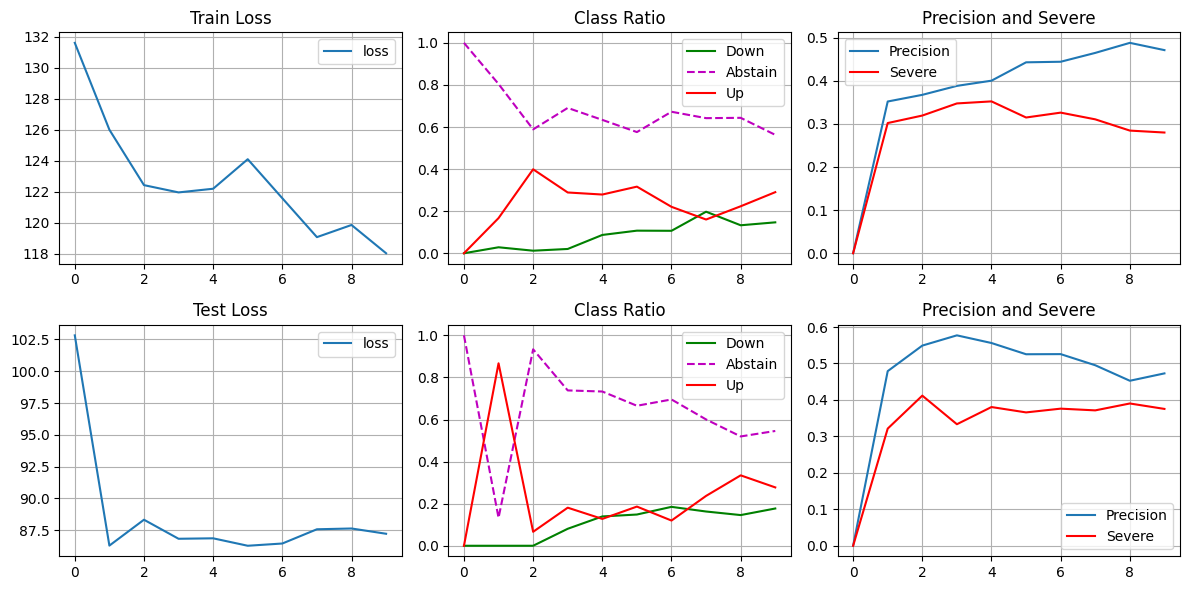

100%|██████████| 2/2 [00:00<00:00, 311.62it/s]


In [ ]:
# --- 运行优化 ---
if __name__ == "__main__":
    # 我们要最大化准确率
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30)  # 运行30次试验

    print("优化完成!")
    print("最佳试验的编号: ", study.best_trial.number)
    print("最佳准确率: ", study.best_value)
    print("最佳超参数: ", study.best_params)

In [ ]:
# all_assets = pd.DataFrame({
#     'stage_1_prediction': np.mean(result, axis = 0)[:,0],
#     'stage_2_prediction': np.mean(result, axis = 0)[:,2],

#     'stage_1_precision': np.mean(result, axis = 0)[:,1],
#     'stage_2_precision': np.mean(result, axis = 0)[:,3],

#     'stage_1_precision_std': np.std(result, axis = 0)[:,1],
#     'stage_2_precision_std': np.std(result, axis = 0)[:,3],
# })
# all_assets.index = pd.Series(assets_list)
# for col in all_assets.columns:
#     all_assets[col] = all_assets[col].apply(lambda x: f"{x:.1%}")

# # 转换为Markdown
# markdown_table = all_assets.to_markdown(index=False)
# print(f'hidden_size: {hidden_size}, num_layers: {num_layers}, seq_len: {seq_len}')
# print(markdown_table)

hidden_size: 10, num_layers: 1, seq_len: 20
| stage_1_prediction   | stage_2_prediction   | stage_1_precision   | stage_2_precision   | stage_1_precision_std   | stage_2_precision_std   |
|:---------------------|:---------------------|:--------------------|:--------------------|:------------------------|:------------------------|
| 20.8%                | 0.0%                 | 20.7%               | 0.0%                | 6.6%                    | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |


hidden_size: 10, num_layers: 1, seq_len: 20
| stage_1_prediction   | stage_2_prediction   | stage_1_precision   | stage_2_precision   | stage_1_precision_std   | stage_2_precision_std   |
|:---------------------|:---------------------|:--------------------|:--------------------|:------------------------|:------------------------|
| 15.3%                | 0.0%                 | 19.0%               | 0.0%                | 12.3%                   | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |

hidden_size: 10, num_layers: 1, seq_len: 20
| stage_1_prediction   | stage_2_prediction   | stage_1_precision   | stage_2_precision   | stage_1_precision_std   | stage_2_precision_std   |
|:---------------------|:---------------------|:--------------------|:--------------------|:------------------------|:------------------------|
| 15.6%                | 0.0%                 | 25.2%               | 0.0%                | 16.7%                   | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |

hidden_size: 10, num_layers: 1, seq_len: 20
| stage_1_prediction   | stage_2_prediction   | stage_1_precision   | stage_2_precision   | stage_1_precision_std   | stage_2_precision_std   |
|:---------------------|:---------------------|:--------------------|:--------------------|:------------------------|:------------------------|
| 23.6%                | 0.0%                 | 11.0%               | 0.0%                | 9.9%                    | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |

hidden_size: 10, num_layers: 1, seq_len: 20
| stage_1_prediction   | stage_2_prediction   | stage_1_precision   | stage_2_precision   | stage_1_precision_std   | stage_2_precision_std   |
|:---------------------|:---------------------|:--------------------|:--------------------|:------------------------|:------------------------|
| 24.2%                | 0.0%                 | 10.0%               | 0.0%                | 13.7%                   | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |